In [1]:
pip install transformers datasets torch torchvision gradio


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 547.8/547.8 kB 6.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.3/12.3 MB 37.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 40.8/40.8 MB 16.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 16.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 64.9/64.9 kB 6.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 12.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 10.6 MB/s eta 0:00:00
  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (23.7 MB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (823 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (14.1 MB)
  Using cached nvidia_cudnn_cu12-8.9.2.26-py3-none-manylinux1_x86_64.whl (731.7 MB)
  Using cached nvidia_cublas_cu12-12.1.3.1-py3-none-manylinux1_x86_64.whl (410

In [2]:
from datasets import load_dataset

# Load the dataset
dataset = load_dataset("Falah/Alzheimer_MRI")

# Inspect the dataset
print(dataset)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


Generating train split:   0%|          | 0/5120 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/1280 [00:00<?, ? examples/s]

DatasetDict({
    train: Dataset({
        features: ['image', 'label'],
        num_rows: 5120
    })
    test: Dataset({
        features: ['image', 'label'],
        num_rows: 1280
    })
})


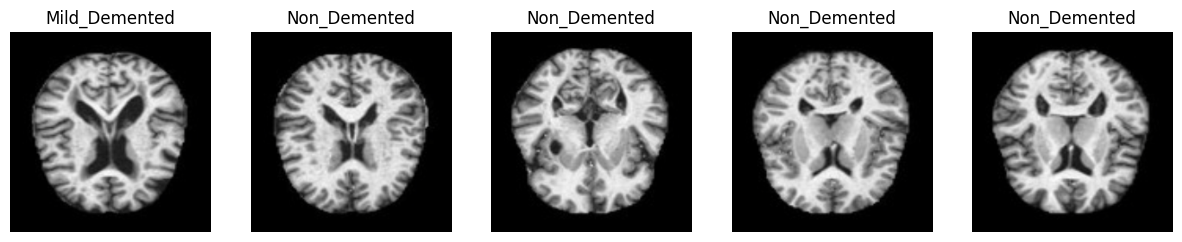

In [3]:
from torchvision import transforms
import matplotlib.pyplot as plt
import random
import numpy as np
# Define the transformation for the images
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.Lambda(lambda img: img.convert("RGB")),  # Convert to RGB
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# Function to plot random images from the train dataset
def plot_random_images(dataset, num_images=5):
    fig, axs = plt.subplots(1, num_images, figsize=(15, 15))

    for i in range(num_images):
        # Randomly select an image from the train dataset
        idx = random.randint(0, len(dataset['train']) - 1)
        sample = dataset['train'][idx]

        # Get the image and label
        image = sample['image']
        label = sample['label']
        label_name = dataset['train'].features['label'].names[label]

        # Apply transformation to the image
        image = transform(image)

        # Convert the tensor to a numpy array for plotting
        image = image.permute(1, 2, 0).numpy()
        image = np.clip(image * np.array([0.229, 0.224, 0.225]) + np.array([0.485, 0.456, 0.406]), 0, 1)

        # Plot the image
        axs[i].imshow(image)
        axs[i].set_title(label_name)
        axs[i].axis('off')

    plt.show()

# Plot random images from the train dataset
plot_random_images(dataset)

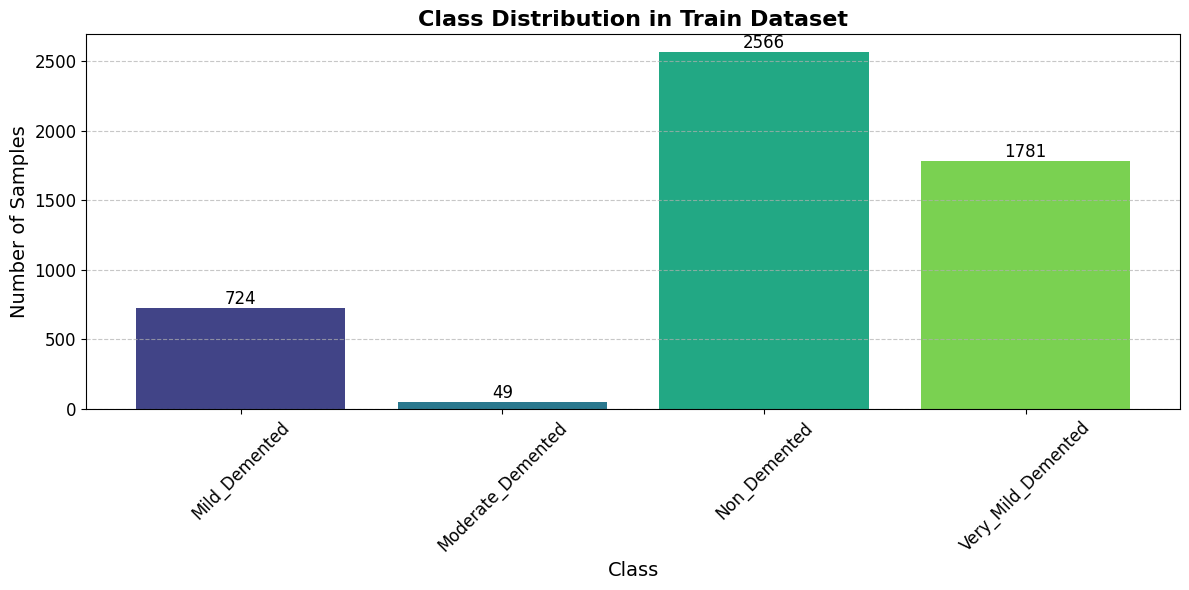

In [4]:
import matplotlib.pyplot as plt
from collections import Counter
from datasets import load_dataset
import seaborn as sns

# Get the train dataset
train_dataset = dataset['train']

# Count the number of samples per class
labels = [sample['label'] for sample in train_dataset]
label_counter = Counter(labels)
class_names = train_dataset.features['label'].names

# Create a color palette
colors = sns.color_palette("viridis", len(class_names))

# Plot the class distribution
plt.figure(figsize=(12, 6))
bars = plt.bar(class_names, [label_counter[i] for i in range(len(class_names))], color=colors)
plt.xlabel('Class', fontsize=14)
plt.ylabel('Number of Samples', fontsize=14)
plt.title('Class Distribution in Train Dataset', fontsize=16, fontweight='bold')
plt.xticks(rotation=45, fontsize=12)
plt.yticks(fontsize=12)
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Add value labels on top of the bars
for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width() / 2.0, height, f'{height}', ha='center', va='bottom', fontsize=12)

# Add a tight layout for better spacing
plt.tight_layout()

# Show the plot
plt.show()

In [6]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
import torchvision.transforms as transforms
from torchvision import models
from datasets import load_dataset

# Custom dataset class
class AlzheimerDataset(Dataset):
    def __init__(self, dataset_split, transform=None):
        self.dataset_split = dataset_split
        self.transform = transform

    def __len__(self):
        return len(self.dataset_split)

    def __getitem__(self, idx):
        image = self.dataset_split[idx]['image']
        label = self.dataset_split[idx]['label']
        if self.transform:
            image = self.transform(image)
        return image, label

# Split dataset into training and validation sets
train_dataset = dataset['train']
val_dataset = dataset['test']

train_data = AlzheimerDataset(train_dataset, transform=transform)
val_data = AlzheimerDataset(val_dataset, transform=transform)

train_loader = DataLoader(train_data, batch_size=16, shuffle=True)
val_loader = DataLoader(val_data, batch_size=16, shuffle=False)

# Load pretrained model and modify the final layer
model = models.resnet50(weights=models.ResNet50_Weights.IMAGENET1K_V1)
model.fc = nn.Linear(model.fc.in_features, 4)  # 4 classes

# Training parameters
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

optimizer = optim.Adam(model.parameters(), lr=0.002, betas=(0.9, 0.999), eps=1e-08)
criterion = nn.CrossEntropyLoss()
num_epochs = 50

# Lists to store metrics
train_losses = []
val_losses = []
val_accuracies = []

# Training loop
for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

    avg_train_loss = running_loss / len(train_loader)
    train_losses.append(avg_train_loss)
    print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {avg_train_loss}")

    # Validation
    model.eval()
    val_loss = 0.0
    correct = 0
    total = 0
    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            val_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    avg_val_loss = val_loss / len(val_loader)
    val_accuracy = correct / total
    val_losses.append(avg_val_loss)
    val_accuracies.append(val_accuracy * 100)
    print(f"Validation Loss: {avg_val_loss}, Accuracy: {100 * correct / total}%")

# Save the model
torch.save(model.state_dict(), "alzheimer_model.pth")



Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth
100%|██████████| 97.8M/97.8M [00:00<00:00, 182MB/s]


Epoch [1/50], Loss: 0.9666981162503362
Validation Loss: 0.9650966212153435, Accuracy: 52.578125%
Epoch [2/50], Loss: 0.8875503182411194
Validation Loss: 0.964703431352973, Accuracy: 56.71875%
Epoch [3/50], Loss: 0.8438583416864276
Validation Loss: 1.6287580162286759, Accuracy: 51.015625%
Epoch [4/50], Loss: 0.7919109098613262
Validation Loss: 0.8394970461726189, Accuracy: 60.625%
Epoch [5/50], Loss: 0.7594592651352287
Validation Loss: 0.7985197100788355, Accuracy: 64.53125%
Epoch [6/50], Loss: 0.6926557298749685
Validation Loss: 0.7380028367042542, Accuracy: 67.1875%
Epoch [7/50], Loss: 0.5833855544682592
Validation Loss: 0.6458866974338889, Accuracy: 71.5625%
Epoch [8/50], Loss: 0.5087373699992895
Validation Loss: 0.6277932519093156, Accuracy: 74.21875%
Epoch [9/50], Loss: 0.44258568226359785
Validation Loss: 0.5151352984830737, Accuracy: 79.765625%
Epoch [10/50], Loss: 0.34885500750970094
Validation Loss: 0.453957705758512, Accuracy: 82.890625%
Epoch [11/50], Loss: 0.2559841972659342

In [7]:
model = models.resnet50(weights=models.ResNet50_Weights.IMAGENET1K_V1)
model.fc = nn.Linear(model.fc.in_features, 4)
model.load_state_dict(torch.load("/content/alzheimer_model.pth"))
model.to(device)
model.eval()

# Prepare the test dataset
test_dataset = dataset['test']
test_data = AlzheimerDataset(test_dataset, transform=transform)
test_loader = DataLoader(test_data, batch_size=16, shuffle=False)

# Evaluate the model on test data
correct = 0
total = 0
test_loss = 0.0
with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        loss = criterion(outputs, labels)
        test_loss += loss.item()
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

avg_test_loss = test_loss / len(test_loader)
test_accuracy = correct / total * 100
print(f"Test Loss: {avg_test_loss}, Test Accuracy: {test_accuracy}%")

Test Loss: 0.20709561281710193, Test Accuracy: 95.9375%


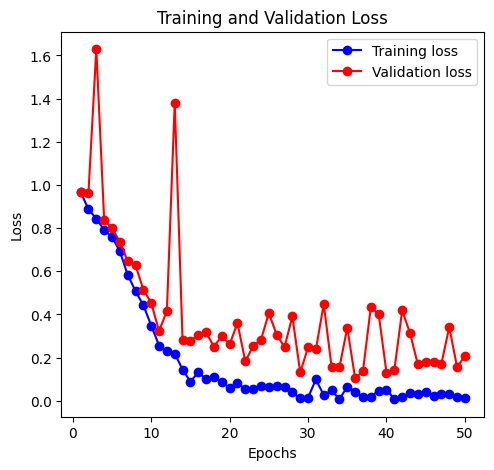

In [8]:
# Plot the training loss, validation loss, and validation accuracy
epochs = range(1, num_epochs + 1)

plt.figure(figsize=(12, 5))

# Loss plot
plt.subplot(1, 2, 1)
plt.plot(epochs, train_losses, 'bo-', label='Training loss')
plt.plot(epochs, val_losses, 'ro-', label='Validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()

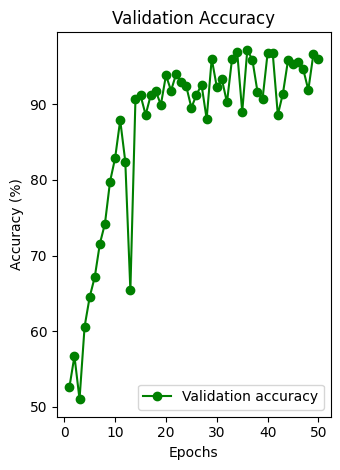

In [9]:
# Accuracy plot
plt.subplot(1, 2, 2)
plt.plot(epochs, val_accuracies, 'go-', label='Validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy (%)')
plt.title('Validation Accuracy')
plt.legend()

plt.tight_layout()
plt.show()